In [170]:
import pandas as pd
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from gensim.models.word2vec import Word2Vec
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kojun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
train = pd.read_csv('train.tsv',sep='\t')
test = pd.read_csv('test.tsv',sep='\t')

In [90]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [91]:
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in forbidden_words]
        return " ".join(text)
    return ""

In [92]:
def average_vec(w2v_model,df):
    _=[]
    for word in df.split(' '):
        if word in w2v_model.wv.index_to_key:
            _.append(w2v_model.wv[word])
        else:
            pass
    vector = np.mean(_,axis=0)
    return vector

In [93]:
train['Phrase'] = train.apply(lambda row:text_cleaning(row['Phrase']),axis=1)
test['Phrase'] = test.apply(lambda row:text_cleaning(row['Phrase']),axis=1)

In [94]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,hearst,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [95]:
vector_size = 300

In [96]:
total = pd.concat([train,test],axis=0).reset_index(drop=True)
w2v_model = Word2Vec(total['Phrase'].apply(lambda x:x.split(' ')),vector_size=vector_size,workers=20,epochs=20,min_count=1) #min_count=1 就不會有空值問題

test= total.apply(lambda row:average_vec(w2v_model,row['Phrase']),axis=1)
g=np.empty(shape=(222352,vector_size))

for i in range(len(test)):
    _=test[i]
#     _ = np.array(test[i])
    g[i]=_

df_g=pd.DataFrame(g)

train_w2v_x = df_g.loc[:156059]
train_w2v_y = total.loc[~total['Sentiment'].isna(),'Sentiment']
test_w2v_x = df_g.loc[156060:]

In [60]:
# def convert_x_dim(train_data_x,train_data_y,past,future):
#     X_train,Y_train = [],[]
#     for i in range(len(train_data_x)-past-future+1):
#         X_train.append(train_data_x.iloc[i:i+past])
#         Y_train.append(train_data_y.iloc[i+past:i+past+future])
#     X_train = np.array(X_train)
#     Y_train = np.array(Y_train)
#     return  X_train,Y_train

In [61]:
# X_train,Y_train = convert_x_dim(train_w2v_x,train_w2v_y,5,1)

In [99]:
x_train,x_vali,y_train,y_vali = train_test_split(train_w2v_x,train_w2v_y,test_size=0.2)

In [100]:
x_train.shape

(124848, 300)

In [168]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
104389,0.059275,-0.497129,-0.128976,0.523302,-0.052811,0.782447,0.522560,0.159178,-0.184658,-0.847803,...,-0.335771,0.318275,-0.336231,0.125133,0.250921,0.733403,0.013442,-0.546530,0.075496,0.098822
76181,0.087034,0.105731,-0.007368,-0.059822,-0.264239,-0.210937,0.351674,-0.023715,-0.033612,0.096005,...,0.225464,0.133836,0.297637,-0.316401,-0.282301,0.276870,0.507698,0.136437,0.171734,-0.168278
79635,0.073897,-0.499294,0.467628,0.490931,0.015566,0.178417,-0.090401,-0.399677,-0.413976,0.126016,...,0.377041,0.078884,-0.151548,0.012483,0.025221,-0.124096,0.007135,-0.381461,0.307011,-0.425857
103079,-0.738877,-2.841879,0.396563,2.068170,-0.029340,1.474912,-0.106108,-0.374922,0.021302,1.500541,...,-1.107453,-1.710459,-1.963964,1.497260,0.432115,1.176040,0.111503,2.147356,-0.535828,-2.861047
14595,-1.070843,0.772438,1.197192,-1.497853,-0.151143,0.370704,-0.431516,-0.091947,0.298710,-0.276188,...,0.946404,-0.611936,0.506939,0.189830,-0.093606,-0.351474,-0.015207,-0.804805,0.159373,-1.243235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41834,-1.301020,0.433837,-0.764430,-0.824970,0.652572,0.174288,-0.429383,-0.127355,1.362644,0.093490,...,-0.237693,-0.131787,0.621273,1.031172,0.612089,0.690693,-0.317292,-0.654373,1.447519,2.104781
135825,-0.435686,-0.023630,-0.156181,0.077863,0.061073,-0.500248,0.043151,0.209083,0.277710,-0.055573,...,-0.399760,0.309685,-0.074181,0.072674,-0.050794,-0.101349,0.006796,-0.108876,0.217234,-0.007683
128539,0.023106,0.289846,0.422603,0.095880,-0.039998,-0.353085,0.133266,-0.298031,0.047518,-0.270312,...,0.418265,0.159708,-0.197126,-0.044035,-0.004337,0.475291,-0.326363,-0.360549,-0.075757,0.433916
71112,-0.314784,-0.385886,0.882836,0.881856,-0.643462,0.357625,-0.145379,0.092376,0.244134,0.074351,...,-0.296846,0.066282,0.032224,0.125582,0.078584,0.615838,0.422168,-0.780394,-0.051163,-0.677454


# DNN model

In [177]:
regular = 5e-4
#,kernel_regularizer=l2(regular),bias_regularizer=l2(regular)
dnn_modedl = tf.keras.models.Sequential([
    
    
    Flatten(input_shape=(300,)),
    
    Dense(units=300,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(regular),bias_regularizer=l2(regular)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=640,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(regular),bias_regularizer=l2(regular)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=320,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(regular),bias_regularizer=l2(regular)),
    BatchNormalization(),
    Dropout(0.5),
            
    Dense(units=5,activation='softmax')
])
dnn_modedl.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 300)               0         
                                                                 
 dense_64 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization_6 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dropout_36 (Dropout)        (None, 300)               0         
                                                                 
 dense_65 (Dense)            (None, 640)               192640    
                                                                 
 batch_normalization_7 (Batc  (None, 640)              2560      
 hNormalization)                                     

In [178]:
Batch_size = 256
Num_of_Epoch = 80

Optimizer_Adam = tf.keras.optimizers.Adam(learning_rate = 1e-3)

Loss_Function = tf.keras.losses.SparseCategoricalCrossentropy()

dnn_modedl.compile(optimizer=Optimizer_Adam,loss=Loss_Function,metrics=['accuracy'])

#學習率排程
def scheduler(epoch,lr):
    if epoch < 20 :
        return lr
    else:
        return lr*tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [179]:
History = dnn_modedl.fit(x=x_train, 
                         y=y_train,
                         batch_size=Batch_size,
                         epochs=Num_of_Epoch,
                         validation_data=(x_vali,y_vali),
                         callbacks=[callback]
                        )

Epoch 1/80
488/488 [==============================] - 7s 11ms/step - loss: 2.4888 - accuracy: 0.4752 - val_loss: 2.0471 - val_accuracy: 0.5551 - lr: 0.0010
Epoch 2/80
488/488 [==============================] - 5s 10ms/step - loss: 1.8538 - accuracy: 0.5504 - val_loss: 1.6351 - val_accuracy: 0.5635 - lr: 0.0010
Epoch 3/80
488/488 [==============================] - 5s 10ms/step - loss: 1.4962 - accuracy: 0.5654 - val_loss: 1.3570 - val_accuracy: 0.5748 - lr: 0.0010
Epoch 4/80
488/488 [==============================] - 5s 10ms/step - loss: 1.2961 - accuracy: 0.5710 - val_loss: 1.2124 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 5/80
488/488 [==============================] - 5s 10ms/step - loss: 1.2013 - accuracy: 0.5752 - val_loss: 1.1474 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 6/80
488/488 [==============================] - 5s 10ms/step - loss: 1.1615 - accuracy: 0.5774 - val_loss: 1.1224 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 7/80
488/488 [==============================] - 5s 11ms/st

488/488 [==============================] - 5s 11ms/step - loss: 0.8956 - accuracy: 0.6598 - val_loss: 0.9470 - val_accuracy: 0.6399 - lr: 4.0762e-05
Epoch 53/80
488/488 [==============================] - 5s 11ms/step - loss: 0.8909 - accuracy: 0.6624 - val_loss: 0.9459 - val_accuracy: 0.6414 - lr: 3.6883e-05
Epoch 54/80
488/488 [==============================] - 5s 10ms/step - loss: 0.8894 - accuracy: 0.6619 - val_loss: 0.9461 - val_accuracy: 0.6410 - lr: 3.3373e-05
Epoch 55/80
488/488 [==============================] - 5s 11ms/step - loss: 0.8869 - accuracy: 0.6619 - val_loss: 0.9447 - val_accuracy: 0.6399 - lr: 3.0197e-05
Epoch 56/80
488/488 [==============================] - 5s 11ms/step - loss: 0.8864 - accuracy: 0.6631 - val_loss: 0.9439 - val_accuracy: 0.6409 - lr: 2.7324e-05
Epoch 57/80
488/488 [==============================] - 5s 11ms/step - loss: 0.8862 - accuracy: 0.6641 - val_loss: 0.9437 - val_accuracy: 0.6413 - lr: 2.4723e-05
Epoch 58/80
488/488 [=========================

In [180]:
loss = History.history["loss"]
accuracy = History.history["accuracy"]
val_loss = History.history["val_loss"]
val_accuracy = History.history["val_accuracy"]

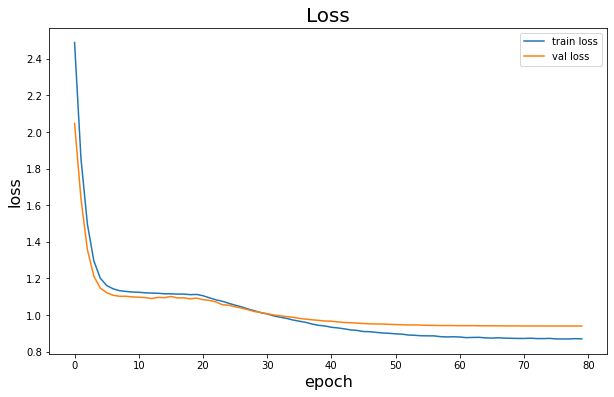

In [181]:
# loss
plt.figure(figsize=(10,6))
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend()
plt.show()

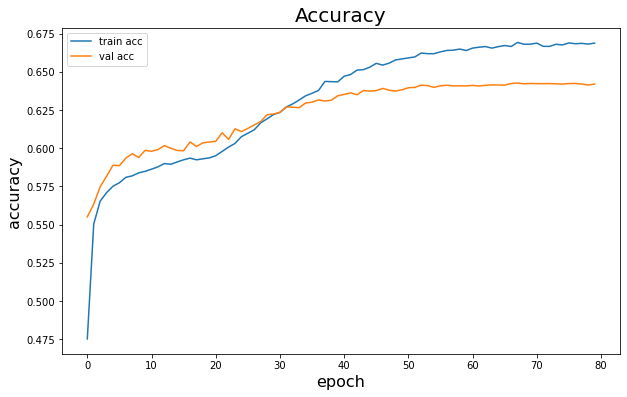

In [182]:
# accuracy
plt.figure(figsize=(10,6))
plt.plot(accuracy, label="train acc")
plt.plot(val_accuracy, label="val acc")
plt.title("Accuracy", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend()
plt.show()


In [186]:
y_pred=dnn_modedl.predict(test_w2v_x)

2072/2072 [==============================] - 4s 2ms/step


In [187]:
y_pred = np.argmax(y_pred,axis=1)

In [196]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([  585,  9612, 41980, 12801,  1314], dtype=int64))

In [200]:
sub = pd.read_csv('sampleSubmission.csv')
sub

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [201]:
sub['Sentiment']=y_pred

In [204]:
sub.to_csv('for_sub.csv',index=False)